# Time Series Forecast - SanFran Data

In [4]:
#load the data
data=scan(file="/Users/dabasn/Desktop/Nitesh/Studies/TimeSeries/TSLabs/SanFran_files/sanfran.dat",skip=1)

In [5]:
#data preprocessing
head(data)
class(data)

[1] 16.26 29.46 18.03 24.13 22.35 22.10

[1] "numeric"

In [6]:
#converting data to a ts object
sanfran<-ts(data,start=c(1932,1),end=c(1966,12),freq=12)

In [7]:
#extract training and test set
library(forecast)
sanfran_train=window(sanfran,start=c(1932,1),end=c(1963,12))
sanfran_test=window(sanfran,start=c(1964,1),end=c(1966,12))

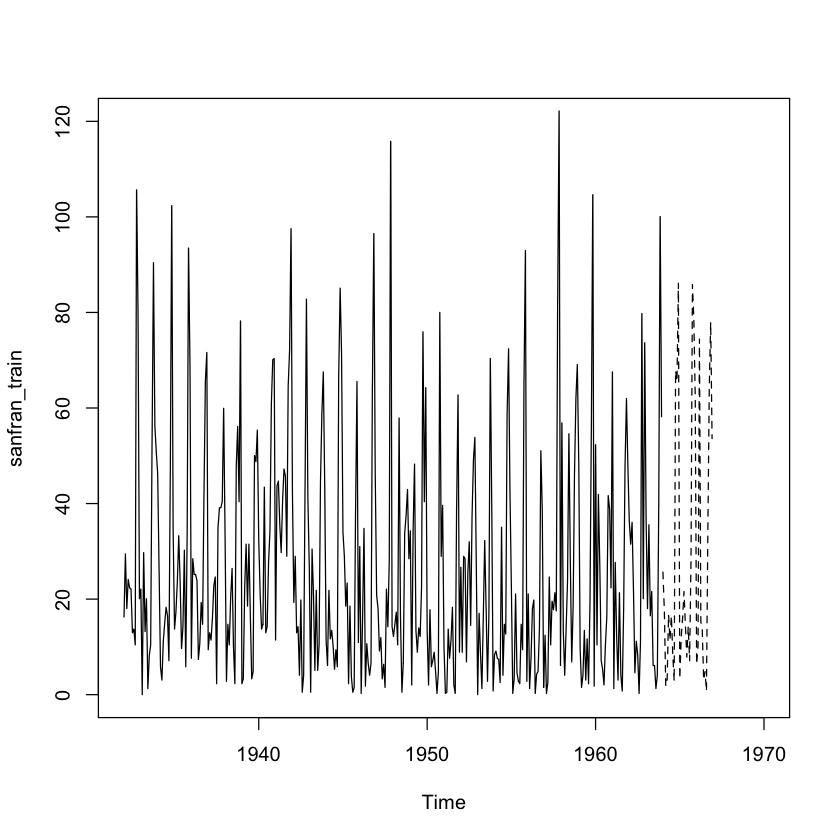

In [8]:
#plot training data
plot(sanfran_train,xlim=c(1932,1970),ylim=c(0,120))
lines(sanfran_test,lty=2)

# Forecasting with exponential smoothing

[1] 15.86614


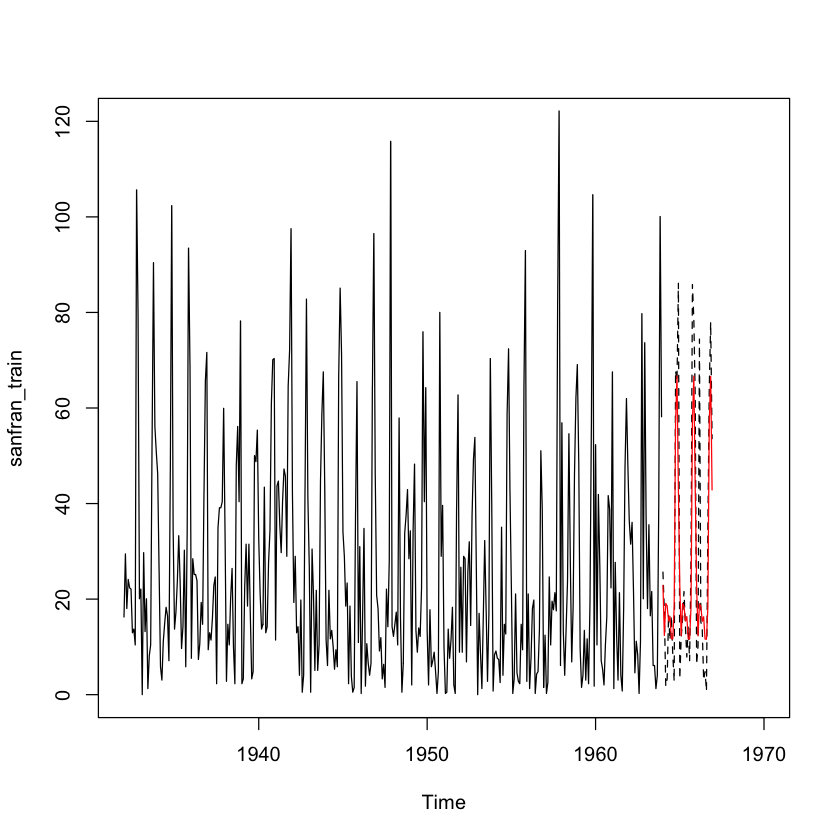

In [9]:
# We see a seasonal pattern, probably additive.
library(forecast)
h=hw(sanfran_train,seasonal='additive',damped=FALSE,h=36)
plot(sanfran_train,xlim=c(1932,1970),ylim=c(0,120))
lines(sanfran_test,lty=2)
lines(h$mean,col=2)

#error
print(sqrt(mean((h$mean-sanfran_test)^2)))

[1] 15.77082


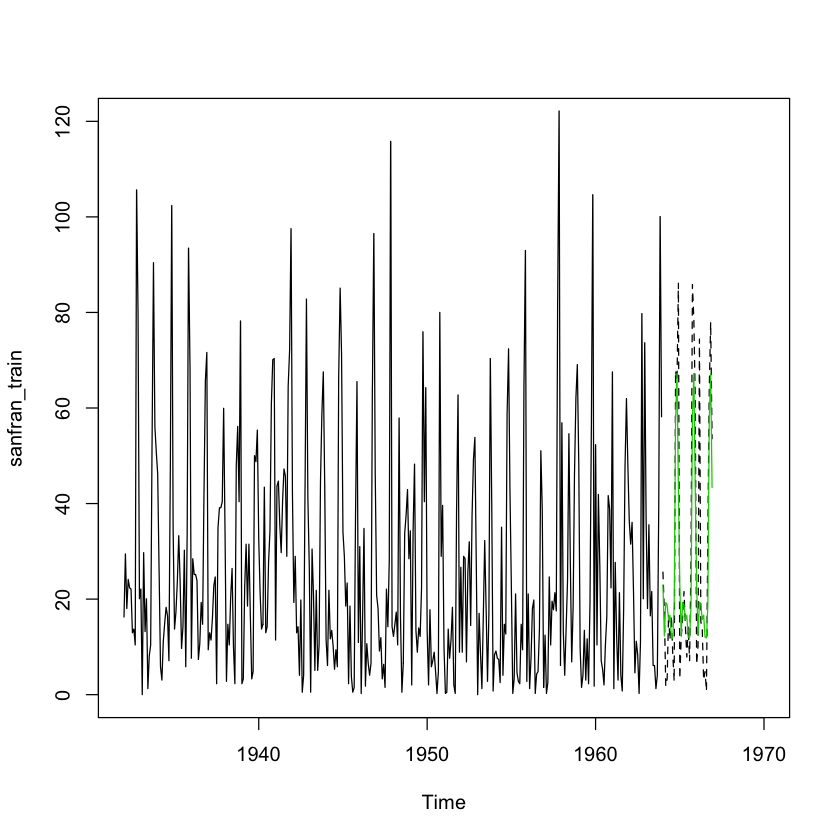

In [10]:
# We can compare with a damped version, the result are slightly better.
hd=hw(sanfran_train,seasonal='additive',damped=TRUE,h=36)
plot(sanfran_train,xlim=c(1932,1970),ylim=c(0,120))
lines(sanfran_test,lty=2)
lines(hd$mean,col=3)

#error
print(sqrt(mean((hd$mean-sanfran_test)^2)))

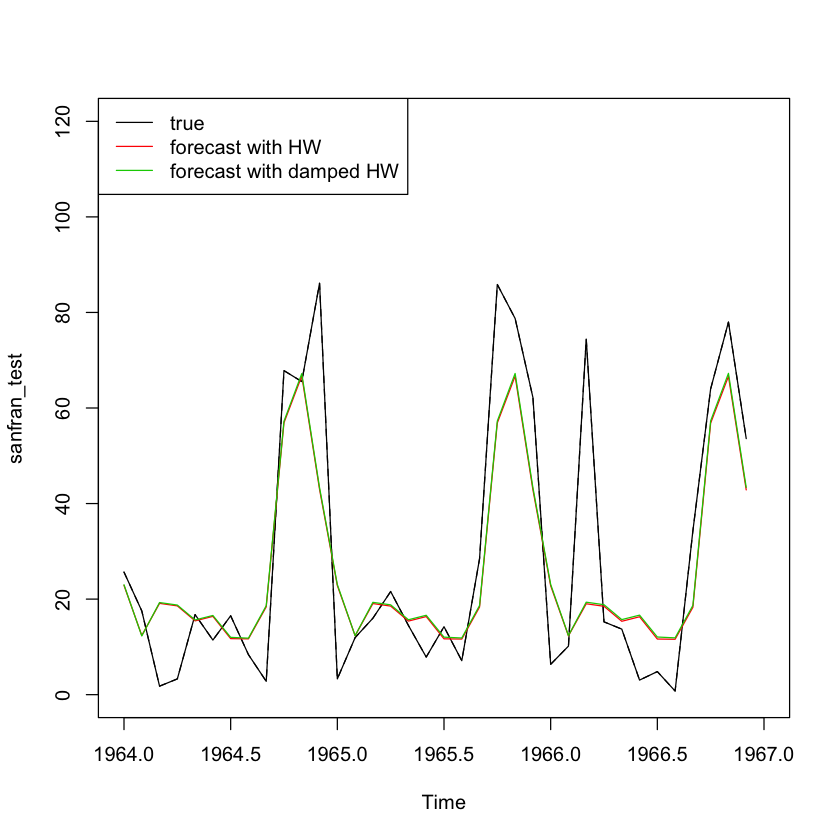

In [11]:
#We can zoom on the prediction
plot(sanfran_test,xlim=c(1964,1967),ylim=c(0,120))
lines(sanfran_test,lty=2)
lines(h$mean,col=2)
lines(hd$mean,col=3)
legend('topleft',col=1:3,lty=1,legend=c('true','forecast with HW','forecast with damped HW'))

The difference is almost null between HW and its damped version. Indeed, if we have a look to the $\phi$ parameter, it is very close to 1 ($\phi=0.9725$): the damping effect is almost null.

# Forecasting with SARIMA

In [12]:
#Try and fit the forecast with Auto Arima
fit=auto.arima(sanfran_train)
summary(fit)
prev=forecast(fit,h=36)

Series: sanfran_train 
ARIMA(0,0,1)(2,1,0)[12] with drift 

Coefficients:
          ma1     sar1     sar2    drift
      -0.0108  -0.6204  -0.2710  -0.0061
s.e.   0.0510   0.0508   0.0521   0.0415

sigma^2 estimated as 327.7:  log likelihood=-1605.73
AIC=3221.46   AICc=3221.62   BIC=3241.05

Training set error measures:
                      ME     RMSE      MAE  MPE MAPE      MASE         ACF1
Training set -0.04091511 17.72204 13.27102 -Inf  Inf 0.8385827 0.0009082292


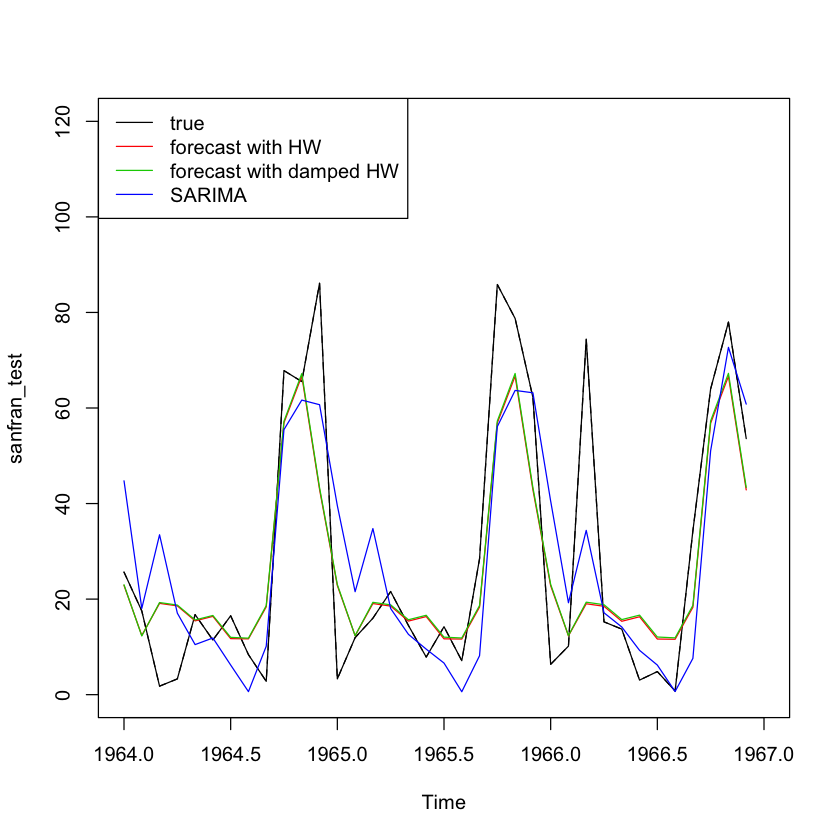

In [13]:
#Comparision of forecasts
plot(sanfran_test,xlim=c(1964,1967),ylim=c(0,120))
lines(sanfran_test,lty=2)
lines(h$mean,col=2)
lines(hd$mean,col=3)
lines(prev$mean,col=4)
legend('topleft',col=1:4,lty=1,legend=c('true','forecast with HW','forecast with damped HW','SARIMA'))

In [14]:
#Error with SARIMA model
print(sqrt(mean((prev$mean-sanfran_test)^2)))

[1] 16.57343


The forecast is infact worse than exponential smoothing. We can try to choose manually the order of the SARIMA model.

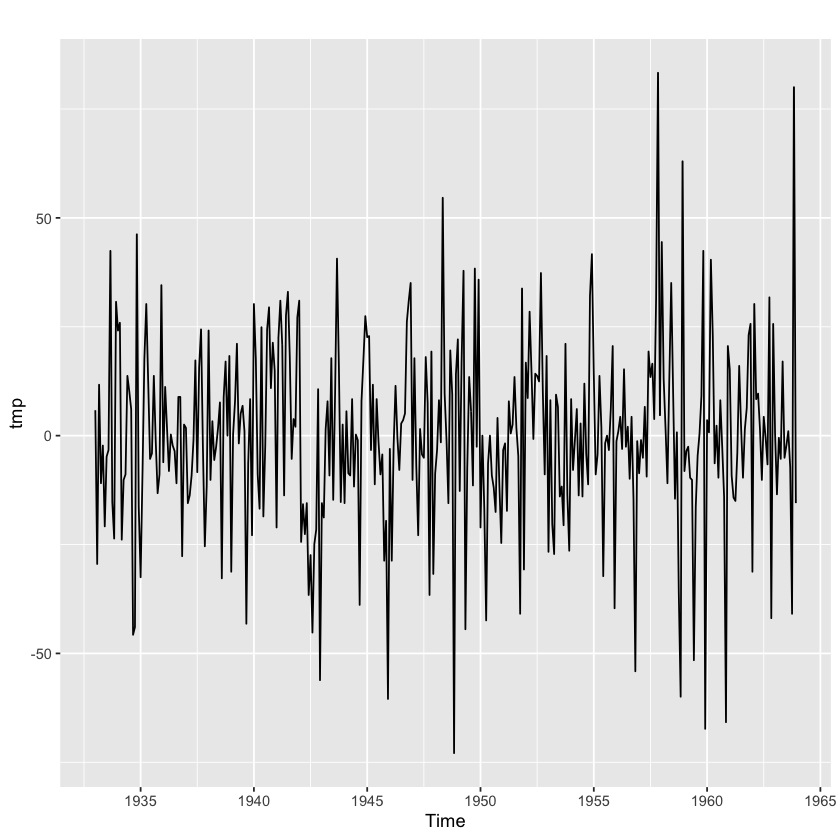

In [15]:
#Let’s start by differenciating the series.
tmp=diff(sanfran_train, lag=12)
autoplot(tmp)

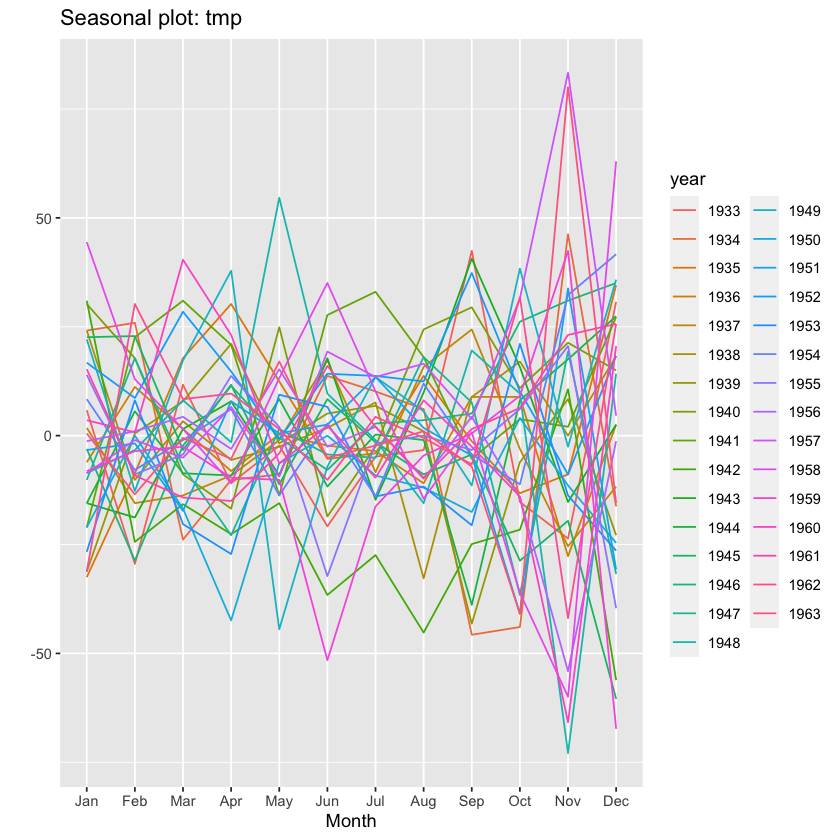

In [16]:
ggseasonplot(tmp)

It seems approximatively stationary. Let’s look at the ACF and PACF.

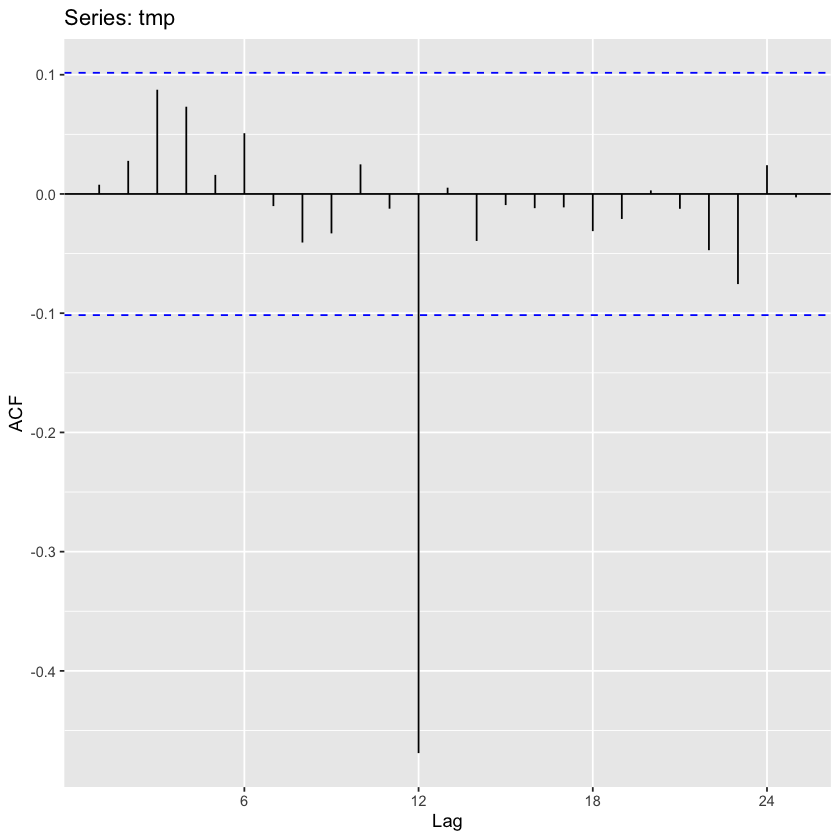

In [17]:
ggAcf(tmp)

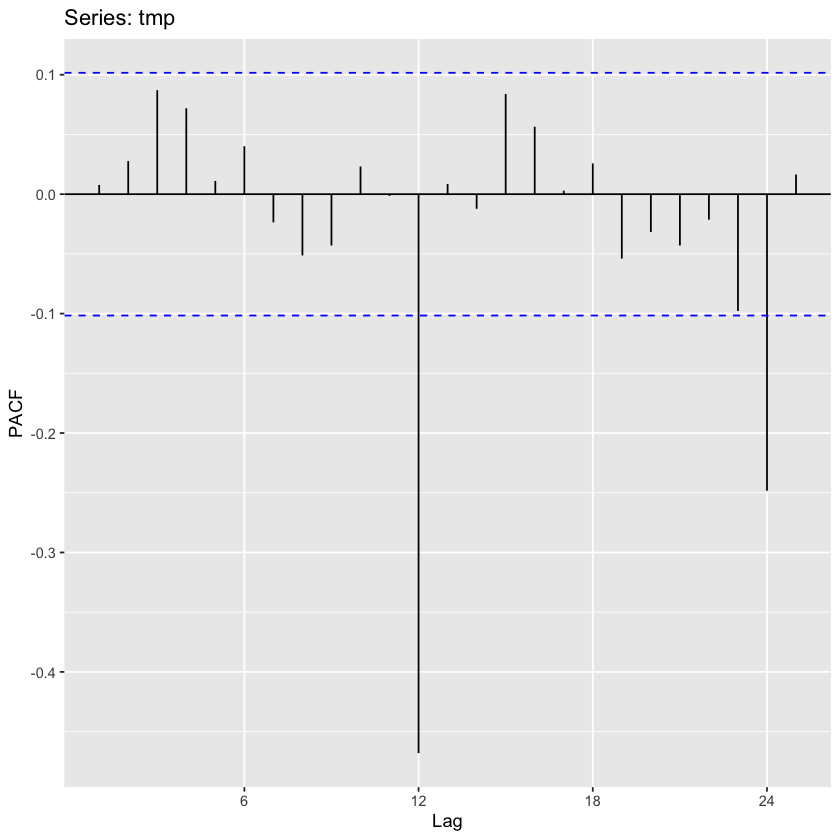

In [18]:
ggPacf(tmp)

We observe significant ACF at lag 12 and exponential decay of the seasonal lags of the PACF.

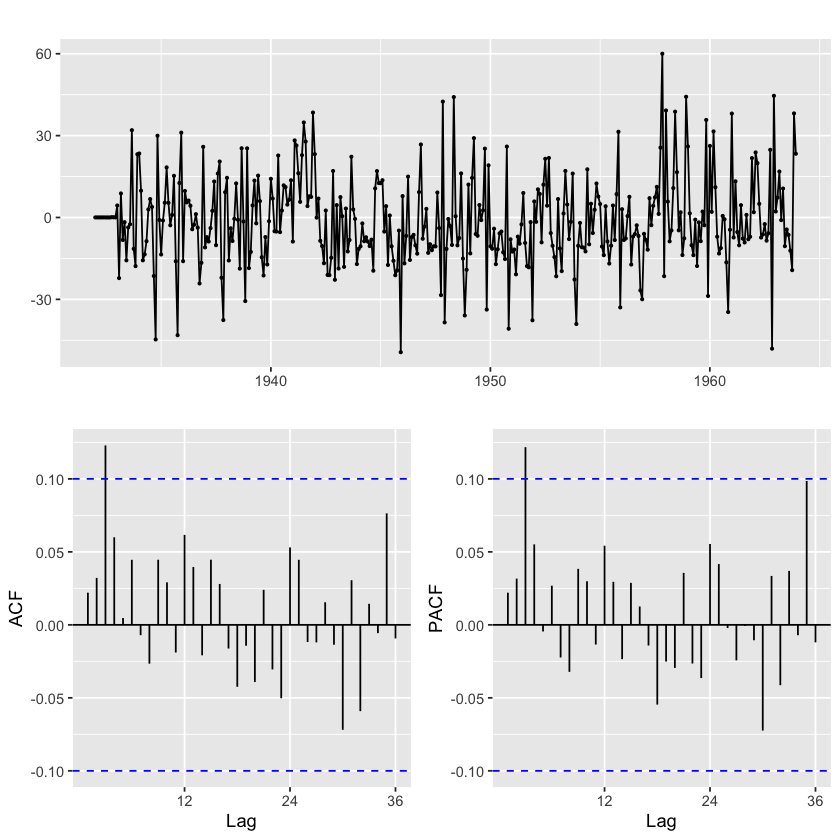

In [19]:
fit=Arima(sanfran_train, order=c(0,0,0), seasonal=c(0,1,1)) 
fit %>% residuals() %>% ggtsdisplay()

We can add some additional non-seasonal terms, with an SARIMA(0,0,3)(0,1,1)12

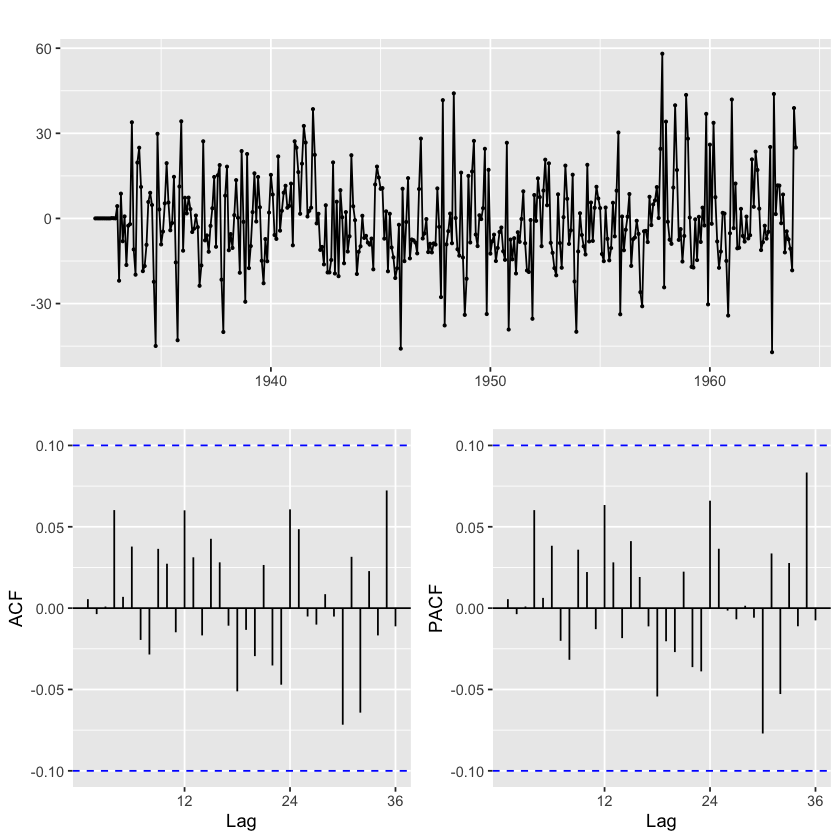

In [20]:
fit1=Arima(sanfran_train, order=c(0,0,3), seasonal=c(0,1,1))
fit1 %>% residuals() %>% ggtsdisplay() 


	Ljung-Box test

data:  Residuals from ARIMA(0,0,3)(0,1,1)[12]
Q* = 11.139, df = 20, p-value = 0.9425

Model df: 4.   Total lags used: 24



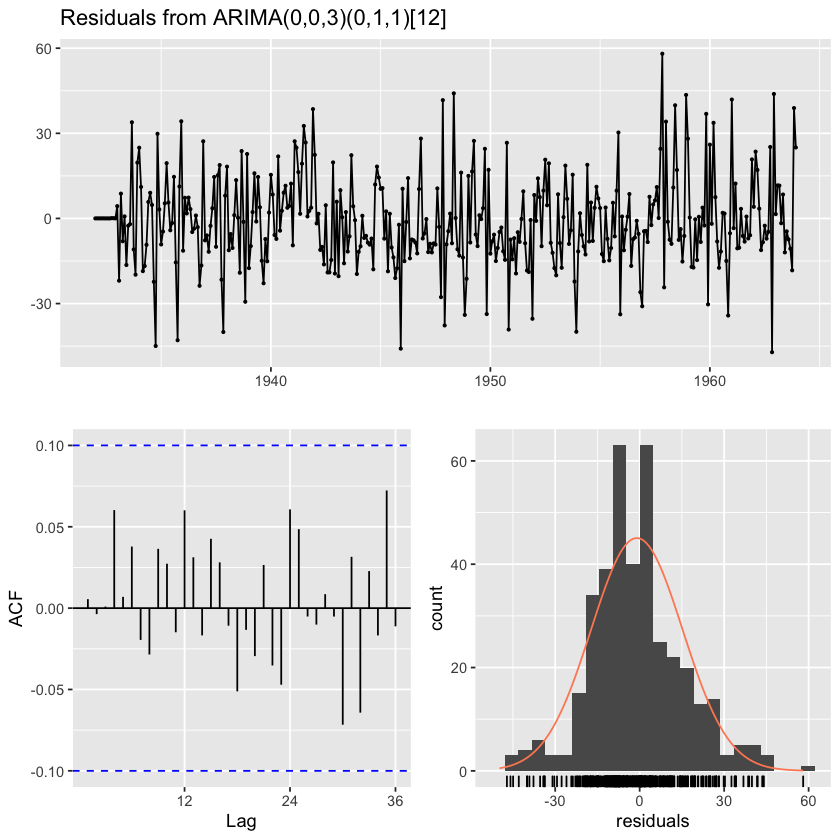

In [21]:
#It seems that we have captured all auto-correlations
checkresiduals(fit1)

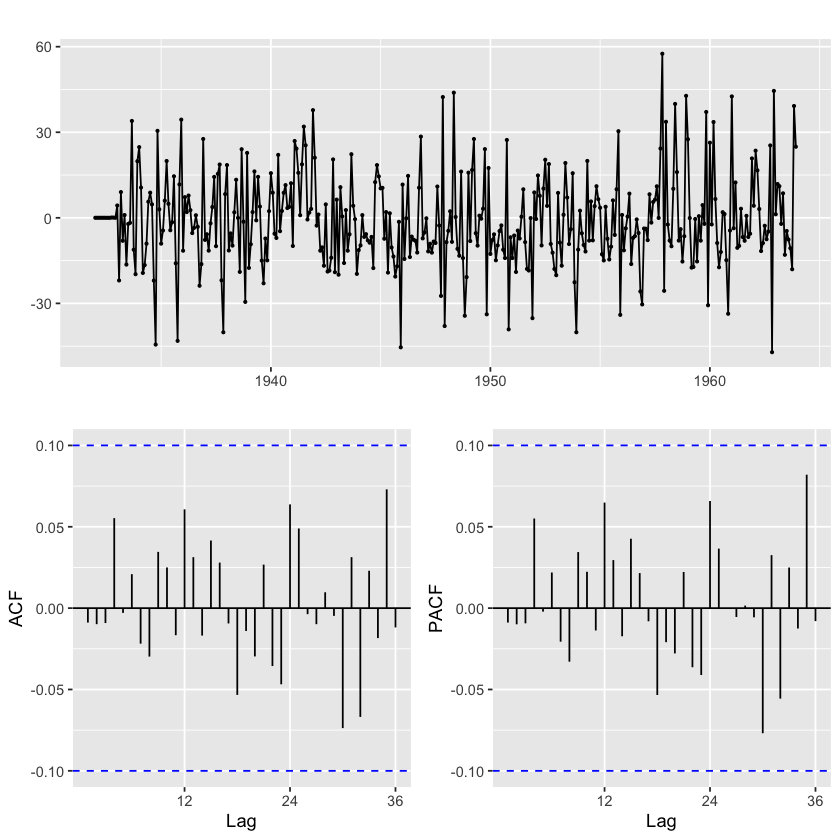

In [22]:
#let us also try SARIMA(3,0,0)(0,1,1)12
fit2=Arima(sanfran_train, order=c(3,0,0), seasonal=c(0,1,1)) 
fit2 %>% residuals() %>% ggtsdisplay() 


	Ljung-Box test

data:  Residuals from ARIMA(3,0,0)(0,1,1)[12]
Q* = 10.834, df = 20, p-value = 0.9504

Model df: 4.   Total lags used: 24



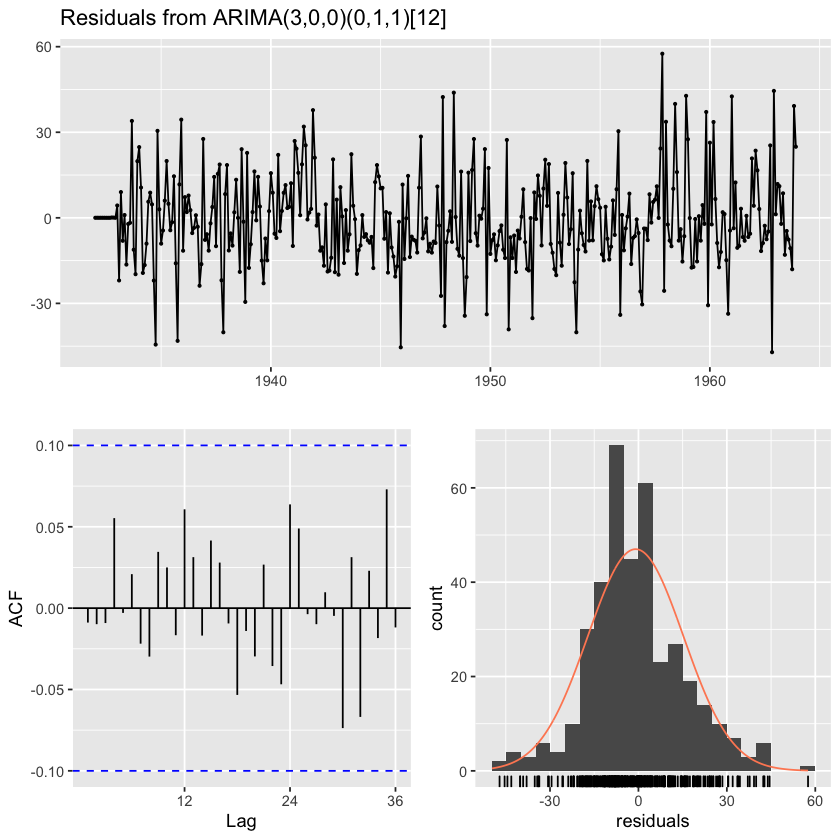

In [23]:
#It seems that we have captured all auto-correlations
checkresiduals(fit2)

Therefore both these models are acceptable. We can compare the AICc.

In [24]:
cat("AICc for SARIMA_{(0,0,3)(0,1,1)_{12}} : ",fit1$aicc,"\n")

AICc for SARIMA_{(0,0,3)(0,1,1)_{12}} :  3171.135 


In [25]:
cat("AICc for SARIMA_{(3,0,0)(0,1,1)_{12}} : ",fit2$aicc,"\n")

AICc for SARIMA_{(3,0,0)(0,1,1)_{12}} :  3170.473 


Second fit is slightly better than first one. Therefore we select it for forecasting. We can forecast the next 30 values and compare the results.

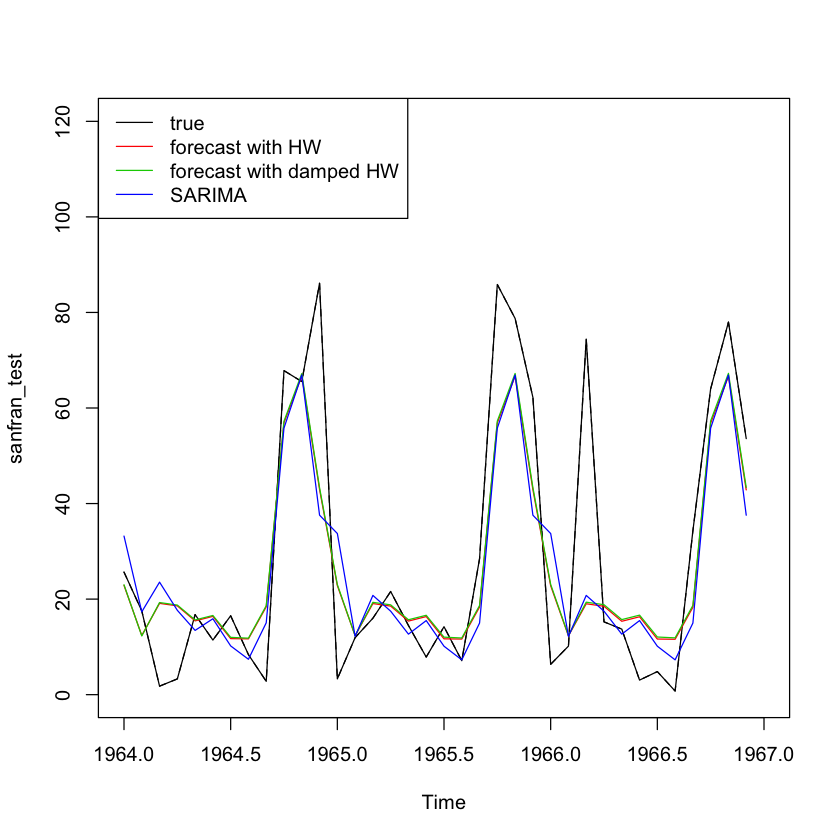

In [26]:
prev=forecast(fit2,h=36)
plot(sanfran_test,xlim=c(1964,1967),ylim=c(0,120))
lines(sanfran_test,lty=2)
lines(h$mean,col=2)
lines(hd$mean,col=3)
lines(prev$mean,col=4)
legend('topleft',col=1:4,lty=1,legend=c('true','forecast with HW','forecast with damped HW','SARIMA'))

In [27]:
#Error with SARIMA model
print(sqrt(mean((prev$mean-sanfran_test)^2)))

[1] 17.49685


Error with Auto.ARIMA model: 16.57343
Error with SARIMA model: 17.49685
Therefore we select ARIMA(0,0,1)(2,1,0)[12] model as predicted by auto.arima model.

# Forecasting with Neural Network

In [34]:
#We try and select automatically the best NNAR(p,P,k)T model:
library(forecast)
fit=nnetar(sanfran_train)
print(fit)

Series: sanfran_train 
Model:  NNAR(4,1,3)[12] 
Call:   nnetar(y = sanfran_train)

Average of 20 networks, each of which is
a 5-3-1 network with 22 weights
options were - linear output units 

sigma^2 estimated as 242.8


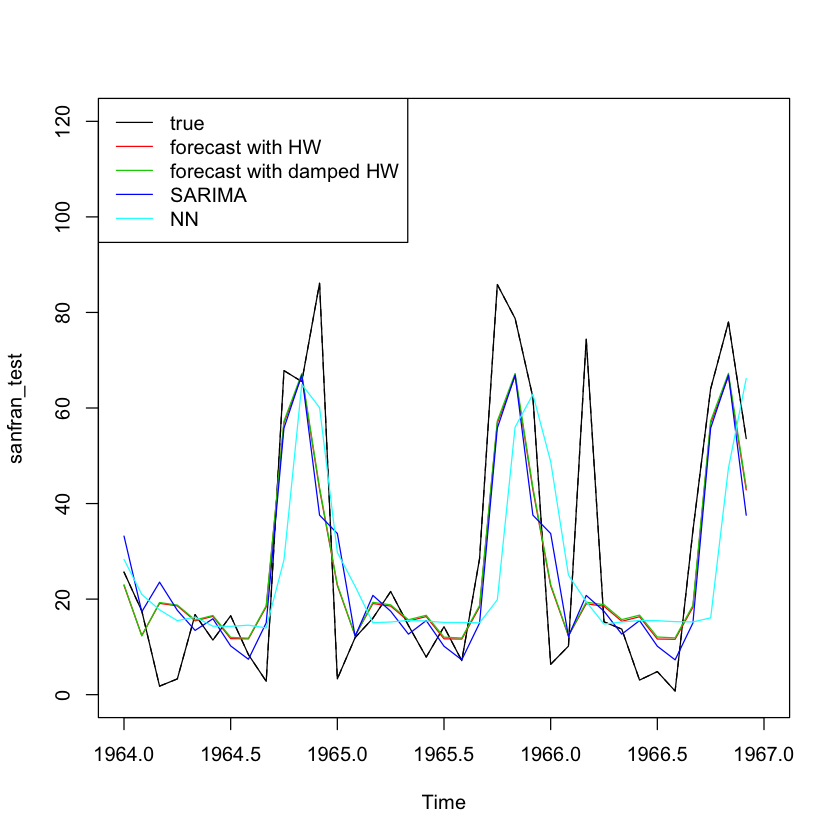

In [35]:
prevNN=forecast(fit,h=36)
plot(sanfran_test,xlim=c(1964,1967),ylim=c(0,120))
lines(sanfran_test,lty=2)
lines(h$mean,col=2)
lines(hd$mean,col=3)
lines(prev$mean,col=4)
lines(prevNN$mean,col=5)
legend('topleft',col=1:5,lty=1,legend=c('true','forecast with HW','forecast with damped HW','SARIMA','NN'))

In [36]:
#Error with NN Model
print(sqrt(mean((prevNN$mean-sanfran_test)^2)))

[1] 22.45675


In [ ]:
Forecasting with NN is less efficient than with HW or SARIMA models.

## we select ARIMA(0,0,1)(2,1,0)[12] model as predicted by auto.arima model.